# Notebook to process mass spectrometry data from the MassBank of North America (MoNA) database.

Data file is .sdf format, each chemical sample is a rdkit Chem.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit import RDLogger

# suppress rdkit error messages
RDLogger.logger().setLevel(RDLogger.CRITICAL)
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from itertools import combinations

import statistics

import seaborn as sns

In [2]:
# # Original files containing all molecules
# file_path = '/home/cmdunham/ChemicalDataGeneration/MoNA_data/MoNA-export-Experimental_Spectra.sdf'
file_path = '/home/cmdunham/ChemicalDataGeneration/MoNA_data/MoNA-export-GC-MS_Spectra.sdf'

# Filtered files containing only mols with InCHIKey identifiers.
# file_path = '/home/cmdunham/ChemicalDataGeneration/data/ms1_ms2_with_inchikey.sdf'
# file_path = '/home/cmdunham/ChemicalDataGeneration/data/gc_ms_with_inchikey.sdf'

original_suppl = Chem.SDMolSupplier(file_path)

# Function Defs:
---


In [3]:
def get_weighted_cosine_similarity(output, target):
    # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
    mz = np.arange(1, len(target)+1)

    numerator = np.sum(mz * output * target)
    output_denom = np.sqrt(np.sum(mz * output**2))
    target_denom = np.sqrt(np.sum(mz * target**2))
    weighted_cosine_similarity = numerator / (output_denom * target_denom)
    return weighted_cosine_similarity

In [4]:
def plot_spectra_comparison(spec1, spec2, comparison_type, window=None):
    _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 6))  
    if not window:
        window = max(len(spec1), len(spec2))

    # Pad the shorter spectrum with zeros
    if len(spec1) < window:
        spec1 += [0] * (window - len(spec1))
    elif len(spec2) < window:
        spec2 += [0] * (window - len(spec2))
    numbers = range(0,window)

    ax[0].bar(numbers, spec1[:window])
    ax[0].set_title(comparison_type, fontsize=20)
    ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
    ax[0].set_ylabel('Intensity', fontsize=16)

    ax[1].bar(numbers, spec2[:window])
    ax[1].set_title(f'MSD between spectra: {round(MSE(spec1[:window], spec2[:window]),2)}', fontsize=20)
    ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
    ax[1].set_ylabel('Intensity', fontsize=16)

    plt.show()

In [5]:
def format_spectrum(chem):
    spectrum = chem.GetProp("MASS SPECTRAL PEAKS")
    spectrum = spectrum.split(' ')
    spectrum = [item.split('\n') for item in spectrum]
    spectrum = [i for item in spectrum for i in item]

    # the weights are currently at even indices in the list and their
    # frequencies are at odd. Dividing into two lists
    weights = []
    frequencies = []
    for i, num in enumerate(spectrum):
      if i % 2 == 0:
        num = round(float(num))
        weights.append(num)
      else:
        frequencies.append(float(num))

    # some of the spectra have a base peak of 1 instead of 100. Scaling those spectra here
    base_peak = max(frequencies)
    if base_peak != 100:
      frequencies = [freq/base_peak * 100 for freq in frequencies]


    # creating list to hold frequency of each weight - with 0s for weights with no data
    max_length = max(weights)
    weight_frequencies = [0] * max_length

    # filling in with mass spec data for the specific chemical
    for i in range(len(weight_frequencies)):
      if i+1 in weights:
        index = weights.index(i+1)
        weight_frequencies[i] = frequencies[index]

    # return weight_frequencies, max_length
    return weight_frequencies

In [45]:
def get_comparison_spectra(suppl, property, comparison_type, start_point=0, print_mol=False):
    """
    Retrieves the mass spectra for two molecules from the provided molecule supplier (suppl)
    based on the specified property and comparison type.

    Args:
        suppl (Chem.SDMolSupplier): RDKit molecule supplier.
        property (str): The name of the property to use for the comparison.
        comparison_type (str): The type of comparison to perform, either 'same' (two samples of the same chemical with the same experimental condition) 
            or 'different' (two samples of the same chemical with different experimental conditions).
        start_point (int, optional): The index to start the search from. Defaults to 0. The sample at index start_point is used as the first spectrum in the comparison.
            If a fitting comparison spectrum is not found, start_point will increment by 10. Incrementing by 10 was done as there are often many samples in a row 
            for the same chemical/same conditions.

    Returns:
        tuple: A tuple containing the formatted mass spectra for the two molecules and the instance of the property for each spec.
    """
    spectrum_2 = None
    for i, mol in enumerate(suppl):
        # Skip molecules before the start_point
        if i < start_point:
            pass
        # Process the first molecule at the start_point and record its inchikey and the instance of the specified property
        elif i == start_point:
            inchikey = mol.GetProp('INCHIKEY')
            prop = mol.GetProp(property)
            spectrum_1 = format_spectrum(mol)
            if print_mol:
                all_props = mol.GetPropNames()
                for prop_name in all_props:
                    print(prop_name, ':', mol.GetProp(prop_name))
                print('---------------------------------------------')
            # print(mol.GetProp('NAME'))
            # print(inchikey)
            i += 1
        # Process the remaining molecules
        else:
            if comparison_type == 'same':
                # If the INCHIKEY and the property match, use the sample for comparison
                if mol.GetProp('INCHIKEY') == inchikey and mol.GetProp(property) == prop:
                    prop2 = prop
                    spectrum_2 = format_spectrum(mol)
                    if print_mol:
                        all_props = mol.GetPropNames()
                        for prop_name in all_props:
                            print(prop_name, ':', mol.GetProp(prop_name))
                        print('---------------------------------------------')
                    # print(mol.GetProp('NAME'))
                    # print(mol.GetProp('INCHIKEY'))
                    break
            elif comparison_type == 'different':
                # If the INCHIKEY matches but the property is different, use the sample for comparison
                if mol.GetProp('INCHIKEY') == inchikey and mol.GetProp(property) != prop:
                    prop2 = mol.GetProp(property)
                    spectrum_2 = format_spectrum(mol)
                    if print_mol:
                        all_props = mol.GetPropNames()
                        for prop_name in all_props:
                            print(prop_name, ':', mol.GetProp(prop_name))
                        print('---------------------------------------------')
                    # print(mol.GetProp('NAME'))
                    break

    # If no matching sample was found, recursively call the function with a higher start_point
    if not spectrum_2:
        spectrum_1, spectrum_2, prop, prop2  = get_comparison_spectra(suppl, property, comparison_type, start_point+10, print_mol=print_mol)

    return spectrum_1, spectrum_2, prop, prop2

In [7]:
def make_SDMOLSupplier_with_specified_properties(suppl, specified_props, file_path=False):
    """
    Create a new SDMolSupplier containing only the molecules containing all the specified properties.

    Args:
        suppl (Chem.SDMolSupplier): The SDMolSupplier containing the molecules.
        specified_props (list): A list of property names to check for in the molecules.

    Returns:
        Chem.SDMolSupplier: A new SDMolSupplier containing only the molecules with the specified properties.
        total_samples (int): Count of all samples in the supplier.
        usable_samples (int): Count of all non-None samples in the supplier.
        usable_samples_w_specified_properties (int): Count of all non-None samples in the supplier which have the specified properties.
    """
    new_suppl = []  
    total_samples = 0
    usable_samples = 0
    usable_samples_w_specified_properties = 0

    for mol in suppl:
        total_samples += 1
        # Check if the molecule is not None and has all the specified properties
        if mol is not None:
            usable_samples +=1
            if all(mol.HasProp(prop) for prop in specified_props):
                new_suppl.append(mol)  # Add the molecule to the new supplier if it meets the criteria
                usable_samples_w_specified_properties += 1


    # !! This next step is necessary because SDMolSupplier takes a file path to make a new supplier object. !!
    # Create a temporary file path to write the filtered molecules to
    if not file_path:
        file_path  = '/home/cmdunham/ChemicalDataGeneration/MoNA_data/temp_sdf.sdf'
    # Open an SDWriter to write the filtered molecules to a temporary file. 
    with Chem.SDWriter(file_path) as writer:
        for mol in new_suppl:
            writer.write(mol) 
    
    # Create a new SDMolSupplier from the temporary file and return it
    return Chem.SDMolSupplier(file_path), total_samples, usable_samples, usable_samples_w_specified_properties


In [8]:
def make_property_count_dict(suppl, prop):
    """
    Create a dictionary that counts the occurrences of each unique value for a specified property
    across the molecules in the input supplier.

    Args:
        suppl (Chem.SDMolSupplier): The input supplier containing the molecules.
        prop (str): The name of the property to count.

    Returns:
        prop_count_dict (dict): A dictionary where keys are unique property values and values are
        counts of how many times each value appears.
    """

    prop_count_dict = {}
    for mol in suppl:
        if mol is not None: 
            try:
                # Get the value of the specified property for the current molecule
                prop_instance = mol.GetProp(prop)

                # If the property value is already in the dictionary, increment its count by 1
                if prop_instance in prop_count_dict.keys():
                    prop_count_dict[prop_instance] += 1
                # If the property value is not yet in the dictionary, add it with a count of 1
                else:
                    prop_count_dict[prop_instance] = 1
            except:
                # If the molecule does not have the specified property skip
                pass

    return prop_count_dict

# Dataset Overview:
---

Some of the samples in the database contain no information. Determining how many of the total samples are usable (contain information), and how many of the usable samples contain InCHIKey identifiers (more information: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4486400/):

For inchikey_count_dict: Counting number of samples for each chemical (as defined by InCHIKey).
For instrument_count_dict: Counting number of spectra generated using each instrument. Only including in this count the spectra that have a listed instrument type.

In [9]:
# # Only looking at mols with a listed inchikey
# save_file_path = '/home/cmdunham/ChemicalDataGeneration/data/gc_ms_with_inchikey.sdf'
# suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY'], file_path=save_file_path)

In [21]:
suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY', 'SPECTRUM TYPE'], file_path=save_file_path)

In [11]:
# # creating a list of all of all the properties we can access in the metadata
# all_prop_names = set()
# for chem in suppl:
#     if chem is not None:
#         prop_names = chem.GetPropNames()
#         all_prop_names.update(prop_names)

# all_prop_names = list(all_prop_names)
# all_prop_names

In [23]:
print('Number of samples in the database:')
print(f'    Total samples - {len(original_suppl):,}')
# print(f'    Valid samples - {usable_samples:,}')
print(f'    Valid samples with InCHIKey - {len(suppl):,}')

In [13]:
# print(f'Of the total {total_samples:,} samples in the database, {usable_samples_w_inchikey:,}, or {round((usable_samples_w_inchikey/total_samples)*100)}%, are usable samples with InCHIKey identifiers.')
print(f'Of the total {len(original_suppl):,} samples in the database, {len(suppl):,}, or {round((len(suppl)/len(original_suppl))*100)}%, are usable samples with InCHIKey identifiers.')

Of the total 18,914 samples in the database, 18,617, or 98%, are usable samples with InCHIKey identifiers.


In [27]:
inchikey_count_dict = make_property_count_dict(suppl, 'INCHIKEY')

threshold = 5

total_usable_spectra = 0
num_chems = 0

inchikeys_for_chems_past_threshold = []

for chem in inchikey_count_dict:
    if inchikey_count_dict[chem] >= threshold:
        total_usable_spectra += inchikey_count_dict[chem]
        num_chems += 1
        inchikeys_for_chems_past_threshold.append(chem)

print(f'There are {num_chems:,} chemicals with more than the minimum threshold of {threshold} samples in the database for a total of {total_usable_spectra:,} spectra.')

There are 342 chemicals with more than the minimum threshold of 5 samples in the database for a total of 2,171 spectra.


# Looking at the Data:
---

The size of the difference between some of these spectra for the same chemical is confusing. This does not appear to be caused by an error in the code. 

The spectra in the plot below are for the same chemical, in the same lab, using the same type of machinery but they look VERY different. I'm going to dig a little to see if I can figure out what's going on here.

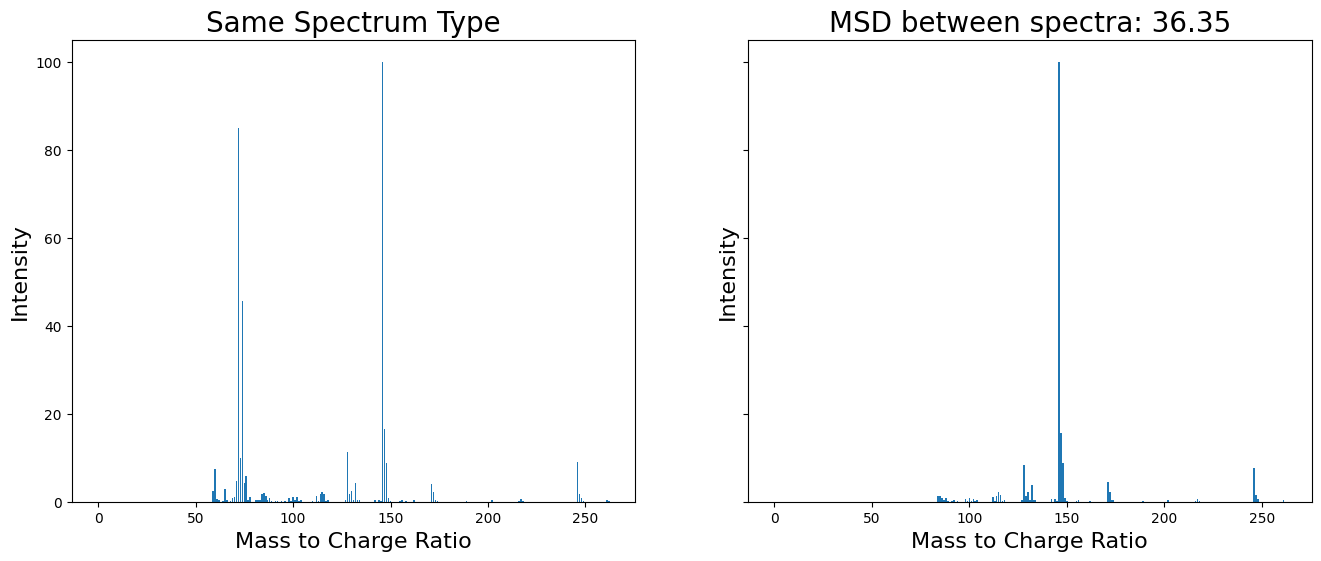

In [49]:
file_path = '/home/cmdunham/ChemicalDataGeneration/data/gc_ms_with_inchikey.sdf'
suppl = Chem.SDMolSupplier(file_path)
spec1, spec2, prop1, prop2 = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same', 10)
plot_spectra_comparison(spec1, spec2, 'Same Spectrum Type')

In [29]:
all_spectra_list = []
inchikeys = []
for mol in suppl:
    try:
        # some of the samples contain only 0s, filtering those out
        if sum(format_spectrum(mol)) != 0:
            all_spectra_list.append(format_spectrum(mol))
            inchikeys.append(mol.GetProp('INCHIKEY'))
    except:
        pass

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df['InCHIKey'] = inchikeys
all_spectra_df = all_spectra_df.fillna(0)
all_spectra_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2448,2449,2450,2451,2452,2453,2454,2455,2456,InCHIKey
0,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SJBLBJCIOBWHAC-UHFFFAOYSA-N
1,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KPJQHWSCXRGXAB-UHFFFAOYSA-N
2,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KPJQHWSCXRGXAB-UHFFFAOYSA-N
3,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PHHRZFRBFLDDTQ-UHFFFAOYSA-N
4,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,REWAKYJADCBFMU-UFSSTKFDSA-N


In [30]:
# Count the frequency of each chemical
inchikey_counts = all_spectra_df['InCHIKey'].value_counts()

# Drop rows for chemicals that only appears once or twice
chems_above_threshold = all_spectra_df[all_spectra_df['InCHIKey'].isin(inchikey_counts[inchikey_counts > 2].index)]

# Drop rows that have only 0s 
chems_above_threshold = chems_above_threshold.loc[(chems_above_threshold.iloc[:, :-1]!=0).any(axis=1)]

In [31]:
average_sims = {}
sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for inchikey in list(set(chems_above_threshold['InCHIKey'])):
    chem_similarities = []
    chem_subset = chems_above_threshold.loc[chems_above_threshold['InCHIKey'] == inchikey]
    chem_subset = chem_subset.drop('InCHIKey', axis=1).T
    highest_nonzero = [np.where(chem_subset[i])[0].max() for i in chem_subset.columns]
    highest_nonzero = max(highest_nonzero)
    for i, j in combinations(chem_subset.columns, 2):
        similarity = MSE(chem_subset[i][:highest_nonzero], chem_subset[j][:highest_nonzero])
        chem_similarities.append(round(similarity, 2))
    
    sims[inchikey] = chem_similarities
    avg_sim = np.mean(chem_similarities)
    # print(avg_sim)
    average_sims[inchikey] = avg_sim

In [32]:
# A couple chemicals have NaNs, something to look into later but removing for now
nans = [key for key, value in average_sims.items() if np.isnan(value)]
for key in nans:
    del average_sims[key]
any(np.isnan(value) for value in average_sims.values())

False

In [33]:
diffs = list(average_sims.values())

# Calculate summary statistics to understand a little better the variation of spectra across the dataset
mean_val = statistics.mean(diffs)
median_val = statistics.median(diffs)
stdev_val = statistics.stdev(diffs)
variance_val = statistics.variance(diffs)

print('Minimum: ', min(diffs))
print(f'Maximum: {max(diffs):.2f}')
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {stdev_val:.2f}")
print(f"Variance: {variance_val:.2f}")

Minimum:  0.10000000000000002
Maximum: 342.83
Mean: 56.40
Median: 42.48
Standard Deviation: 50.78
Variance: 2578.48


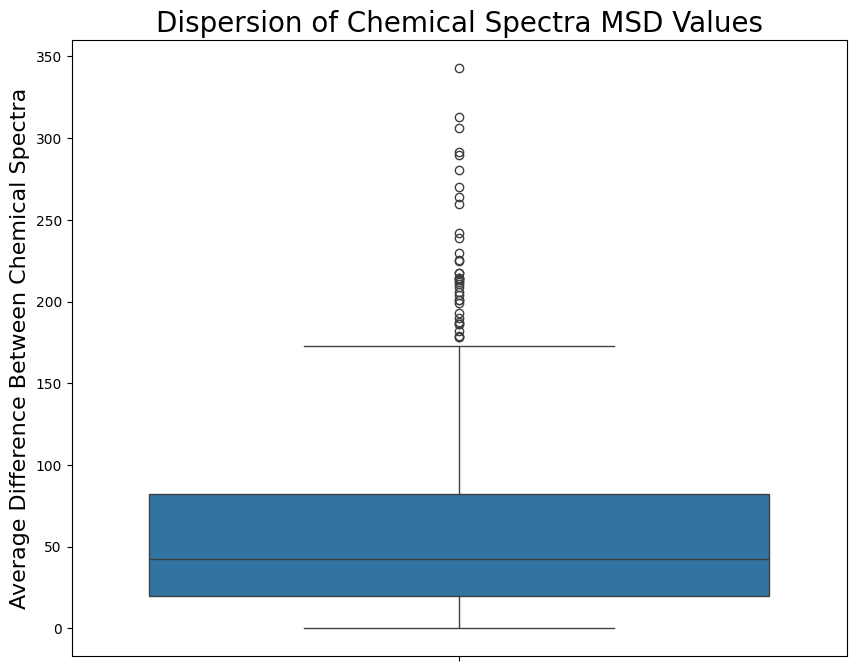

In [34]:
plt.figure(figsize=(10, 8))
sns.boxplot(diffs)

plt.ylabel('Average Difference Between Chemical Spectra', fontsize=16)
plt.title('Dispersion of Chemical Spectra MSD Values', fontsize=20)

plt.show()

Would be interesting to see this broken down by chemical (for at least the most common chemicals). There are too many chemicals in the dataset to display on one plot so I'll limit to the most common spectra.

In [35]:
spectra_sims_list = list(sims.items())

# Sort the list by length of value lists in descending order
spectra_sims_list.sort(key=lambda x: len(x[1]), reverse=True)

# Extract the most common chemical names
most_common_chems = [key for key, _ in spectra_sims_list[:20]]

# Create a new dictionary with the top chemicals
most_common_chems = {key: sims[key] for key in most_common_chems}

/tmp/ipykernel_154325/4290521458.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)


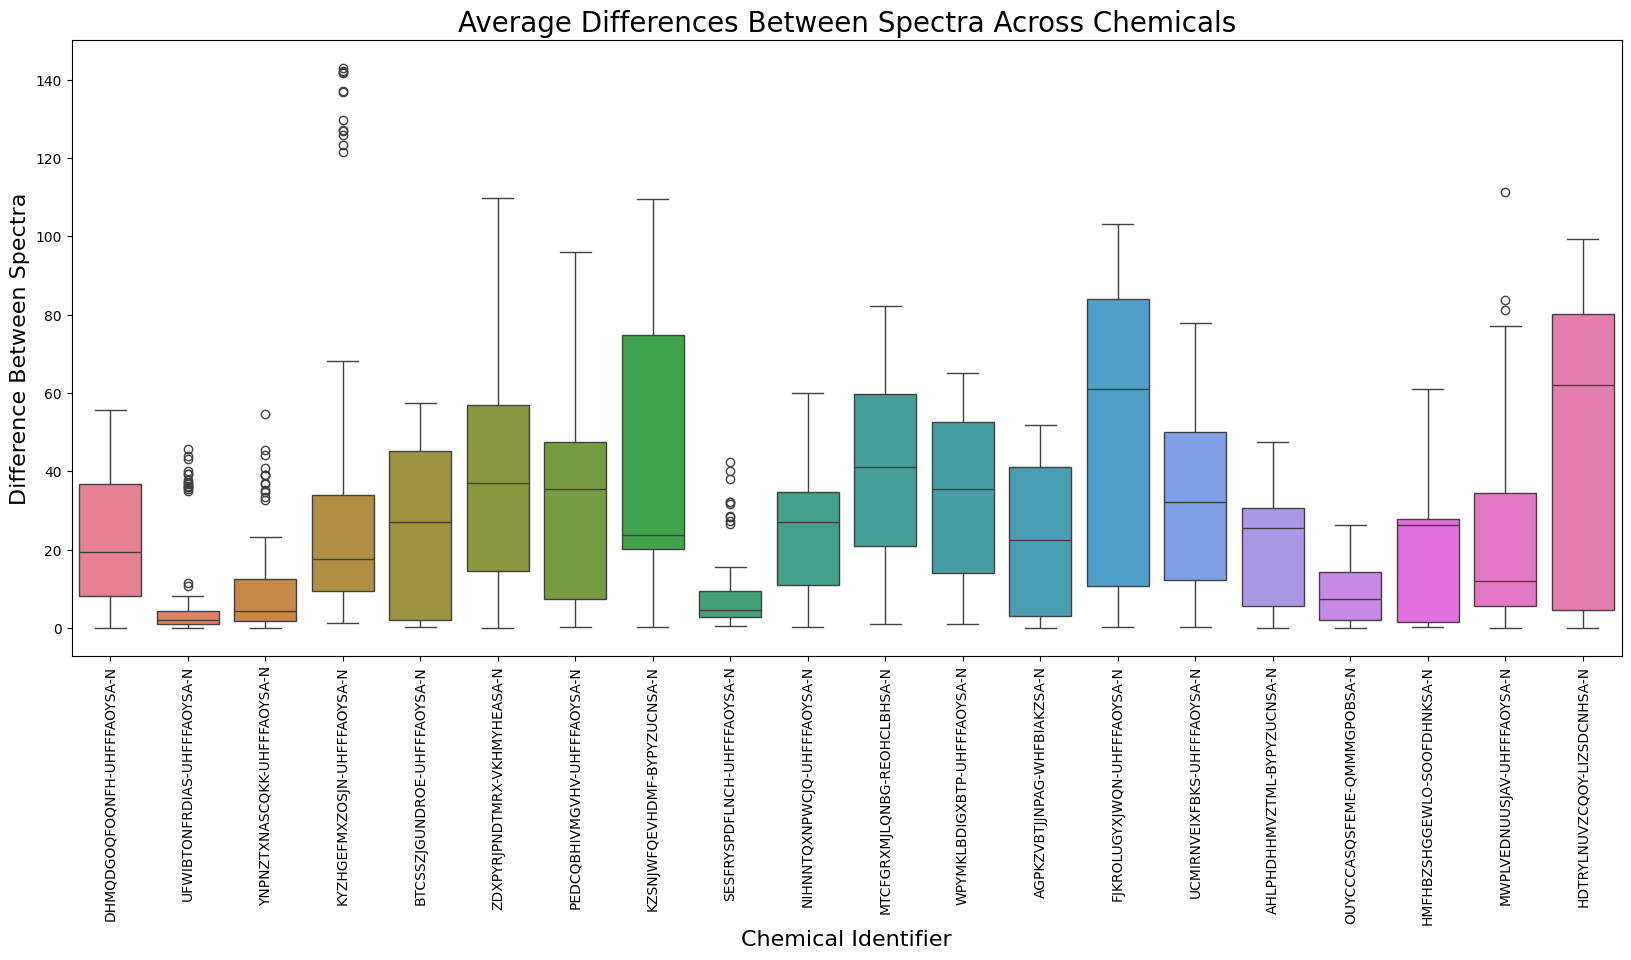

In [36]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create the boxplot
sns.boxplot(data=list(most_common_chems.values()), ax=ax)

ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)

plt.ylabel('Difference Between Spectra', fontsize=16)
plt.xlabel('Chemical Identifier', fontsize=16)
plt.title('Average Differences Between Spectra Across Chemicals', fontsize=20)

plt.show()

# So far only looked at MSE. Should really do this with weighted cosine and compare

# Comparison with other MoNA dataset of all experimental spectra:
---
MoNA has a much larger dataset of experimental spectra (~12 times larger than the dataset used above). When I looked into this dataset I found that the variation between spectra was significantly larger, even for samples prepared under the same experimental conditions. I don't know why that discrepancy exists, but I'd like to get opinions from the chemistry side.

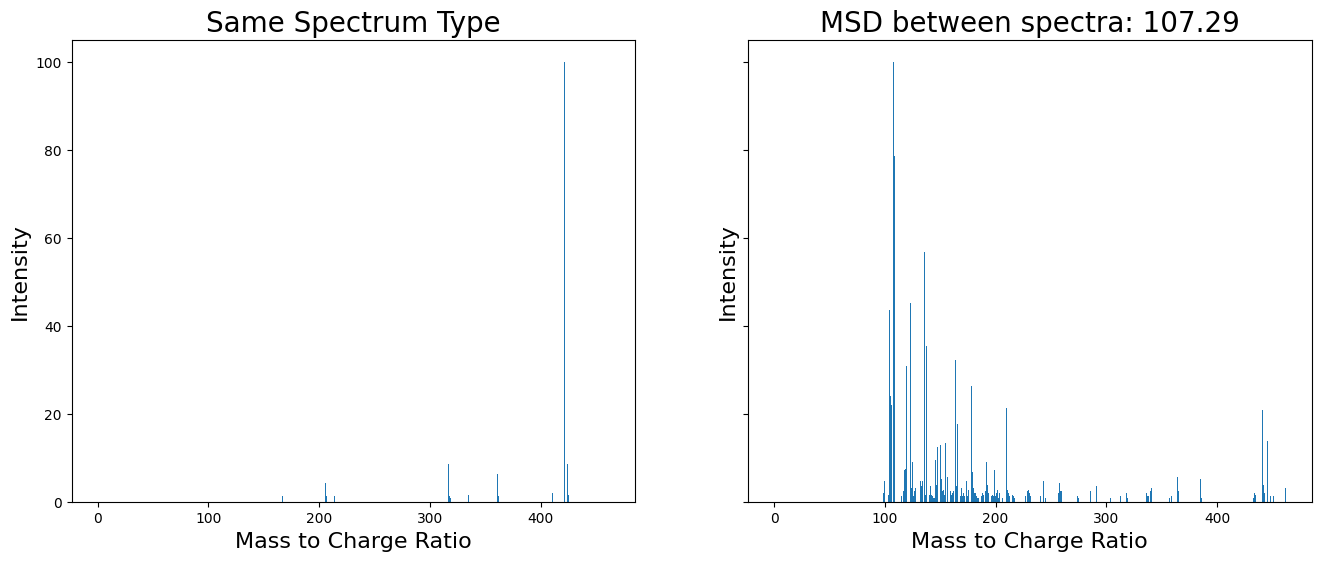

In [61]:
file_path = '/home/cmdunham/ChemicalDataGeneration/data/ms1_ms2_with_inchikey.sdf'
suppl = Chem.SDMolSupplier(file_path)
spec1, spec2, prop1, prop2 = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same', 3)
plot_spectra_comparison(spec1, spec2, 'Same Spectrum Type')

In [62]:
all_spectra_list = []
inchikeys = []
for mol in suppl:
    try:
        # some of the samples contain only 0s, filtering those out
        if sum(format_spectrum(mol)) != 0:
            all_spectra_list.append(format_spectrum(mol))
            inchikeys.append(mol.GetProp('INCHIKEY'))
    except:
        pass

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df['InCHIKey'] = inchikeys
all_spectra_df = all_spectra_df.fillna(0)
all_spectra_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7700,7701,7702,7703,7704,7705,7706,7707,7708,InCHIKey
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N


In [63]:
# Count the frequency of each chemical
inchikey_counts = all_spectra_df['InCHIKey'].value_counts()

# Drop rows for chemicals that only appears once or twice
chems_above_threshold = all_spectra_df[all_spectra_df['InCHIKey'].isin(inchikey_counts[inchikey_counts > 2].index)]

# Drop rows that have only 0s 
chems_above_threshold = chems_above_threshold.loc[(chems_above_threshold.iloc[:, :-1]!=0).any(axis=1)]

In [64]:
average_sims = {}
sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for inchikey in list(set(chems_above_threshold['InCHIKey'])):
    chem_similarities = []
    chem_subset = chems_above_threshold.loc[chems_above_threshold['InCHIKey'] == inchikey]
    chem_subset = chem_subset.drop('InCHIKey', axis=1).T
    highest_nonzero = [np.where(chem_subset[i])[0].max() for i in chem_subset.columns]
    highest_nonzero = max(highest_nonzero)
    for i, j in combinations(chem_subset.columns, 2):
        similarity = MSE(chem_subset[i][:highest_nonzero], chem_subset[j][:highest_nonzero])
        chem_similarities.append(round(similarity, 2))
    
    sims[inchikey] = chem_similarities
    avg_sim = np.mean(chem_similarities)
    # print(avg_sim)
    average_sims[inchikey] = avg_sim

In [65]:
# A couple chemicals have NaNs, something to look into later but removing for now
nans = [key for key, value in average_sims.items() if np.isnan(value)]
for key in nans:
    del average_sims[key]
any(np.isnan(value) for value in average_sims.values())

False

In [66]:
diffs = list(average_sims.values())

# Calculate summary statistics to understand a little better the variation of spectra across the dataset
mean_val = statistics.mean(diffs)
median_val = statistics.median(diffs)
stdev_val = statistics.stdev(diffs)
variance_val = statistics.variance(diffs)

print('Minimum: ', min(diffs))
print(f'Maximum: {max(diffs):.2f}')
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {stdev_val:.2f}")
print(f"Variance: {variance_val:.2f}")

Minimum:  0.0
Maximum: 1370.52
Mean: 58.07
Median: 44.35
Standard Deviation: 69.23
Variance: 4793.21


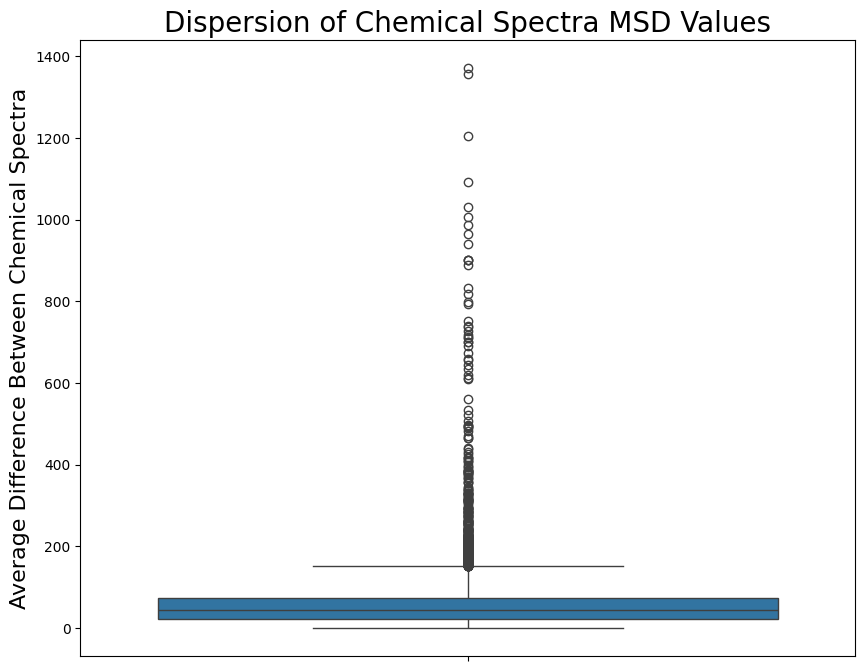

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(diffs)

plt.ylabel('Average Difference Between Chemical Spectra', fontsize=16)
plt.title('Dispersion of Chemical Spectra MSD Values', fontsize=20)

plt.show()

In [68]:
spectra_sims_list = list(sims.items())

# Sort the list by length of value lists in descending order
spectra_sims_list.sort(key=lambda x: len(x[1]), reverse=True)

# Extract the most common chemical names
most_common_chems = [key for key, _ in spectra_sims_list[:20]]

# Create a new dictionary with the top chemicals
most_common_chems = {key: sims[key] for key in most_common_chems}

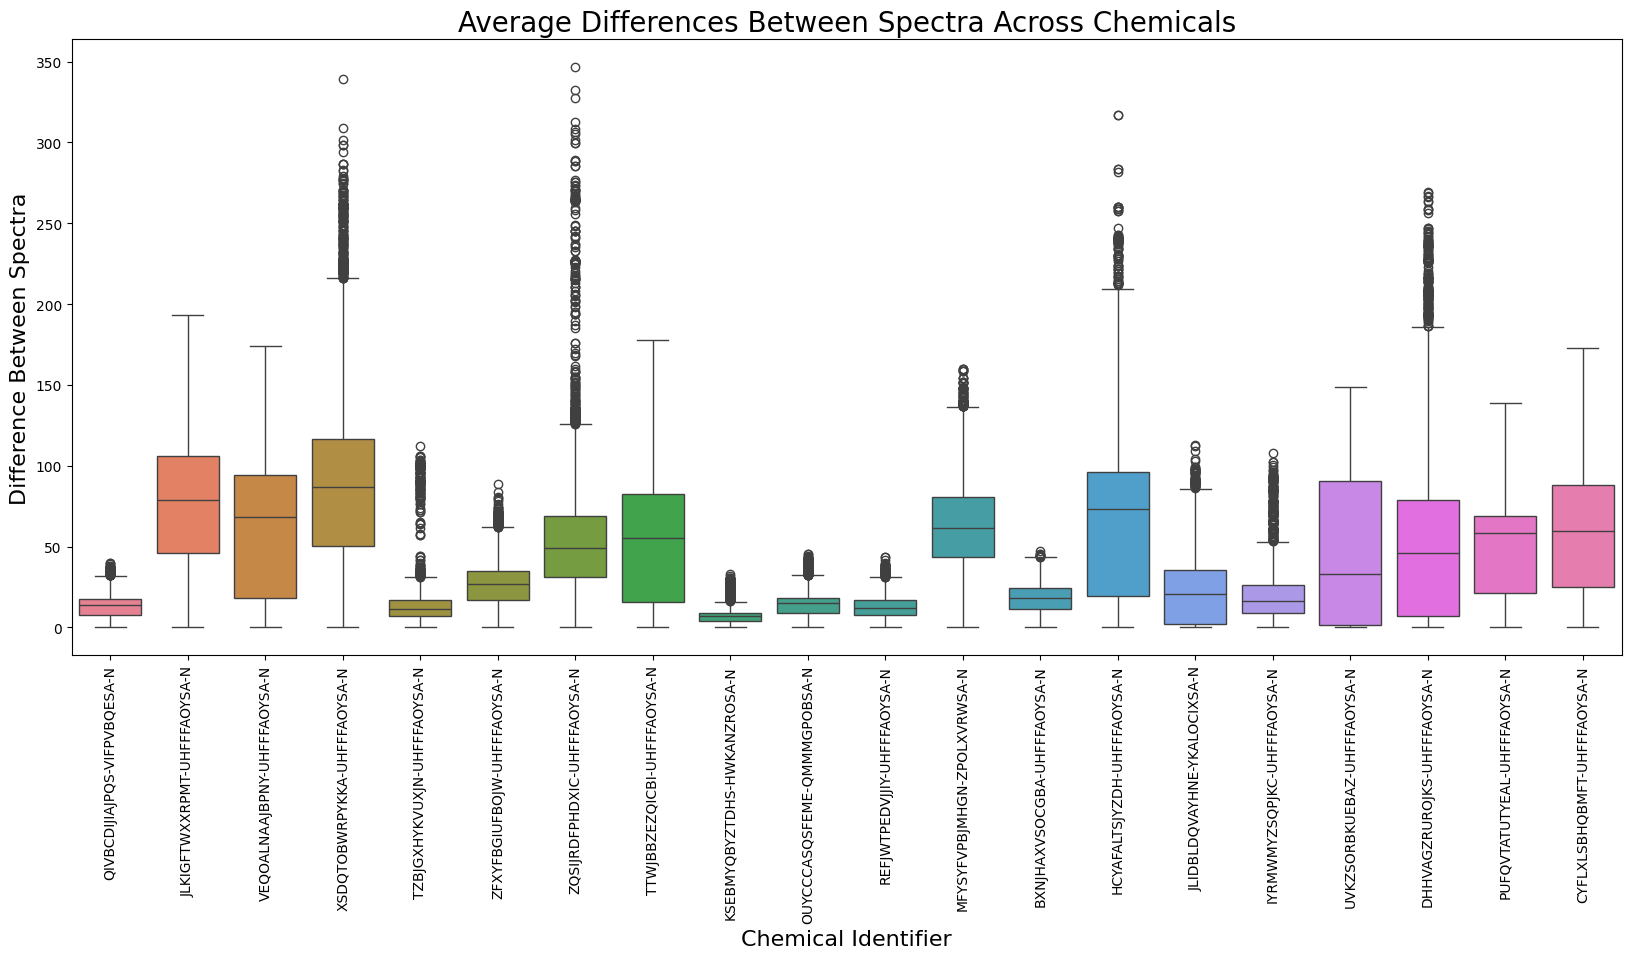

In [69]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create the boxplot
sns.boxplot(data=list(most_common_chems.values()), ax=ax)

plt.xticks(range(len(list(most_common_chems.keys()))), list(most_common_chems.keys()), rotation=90)

plt.ylabel('Difference Between Spectra', fontsize=16)
plt.xlabel('Chemical Identifier', fontsize=16)
plt.title('Average Differences Between Spectra Across Chemicals', fontsize=20)

plt.show()

Looking at this plot we can see that the maximum variation among spectra for the most common chemicals is smaller than for the rest of the dataset (max of ~350 here vs. 1000+ in the full dataset). In both cases it looks like if we set an upper MSE limit of 200 we could still maintain the majority of the data. If we compare to the GC-MS dataset, however, the variation seen here is much higher. 

# SMILES:
---

Chemception needs SMILES strings to generate embeddings. It is possible to represent a chemical using multiple SMILES, but Chemception generates the same embedding for different SMILES pertaining to the same chemical (determined through testing). As such, I will simply select the recorded SMILES corresponding to the first occurance of each chemical in the database.

Since SMILES is not one of the properties we can access directly through the metadata (shown in the Dataset Overview section), we need to determine SMILES by pulling them out of each sample's comment. 

In [12]:
inchikeys_to_use = inchikeys_for_chems_past_threshold.copy()

smiles_dict = {}

for mol in suppl:
  if mol is not None:
    inchikey = mol.GetProp('INCHIKEY')
    if not inchikey in smiles_dict.keys():
      comment = mol.GetProp('COMMENT').split('\n')
      smiles = None
      for line in comment:
        if line.split('=')[0] == 'SMILES':
          smiles = line.split('SMILES=')[1]

      if smiles:
        smiles_dict[inchikey] = smiles

In [15]:
inchikey_smiles_df = pd.DataFrame.from_dict(smiles_dict, orient='index', columns=['SMILES'])
inchikey_smiles_df['InCHIKey'] = inchikey_smiles_df.index

In [16]:
save_file = '/home/cmdunham/ChemicalDataGeneration/data/inchikey_smiles.csv'
with open(save_file, 'w') as f:
  inchikey_smiles_df.to_csv(f, index=False)

# Instrument:
---

In the past we have used the instrument a spectrum was generated on as a condition. We may choose to do this again so it is useful to see more details here.

In [62]:
# making a suppl with only spectra with a listed intrument type in their metadata
instrument_suppl = make_SDMOLSupplier_with_specified_properties(suppl, ['INSTRUMENT TYPE'])
instrument_count_dict = make_property_count_dict(instrument_suppl, 'INSTRUMENT TYPE')

In [55]:
samples_w_inchikey_and_instrument = 0
for val in instrument_count_dict:
    samples_w_inchikey_and_instrument+=instrument_count_dict[val]

print(f'Of the total {usable_samples_w_inchikey:,} usable samples in the database with InCHIKey identifiers, {samples_w_inchikey_and_instrument:,}, or {round((samples_w_inchikey_and_instrument/usable_samples_w_inchikey)*100)}%, list the instrument used in sample generation.')

Of the total 139,929 usable samples in the database with InCHIKey identifiers, 122,721, or 88%, list the instrument used in sample generation.


From the plot below we can see that many more spectra were generated using the LC-ESI-QTOF instrument than any other instrument and that 4 or so instruments were used to generate the majority of the spectra in the dataset. It may be prudent to **combine some of the instruments** that were used for relatively few spectra into a single "Other Instrument" category. We can also see that some of the instruments are broken up into different categories due to naming (GC-EI-TOF for example). We will need to **decide how to handle those categories**.

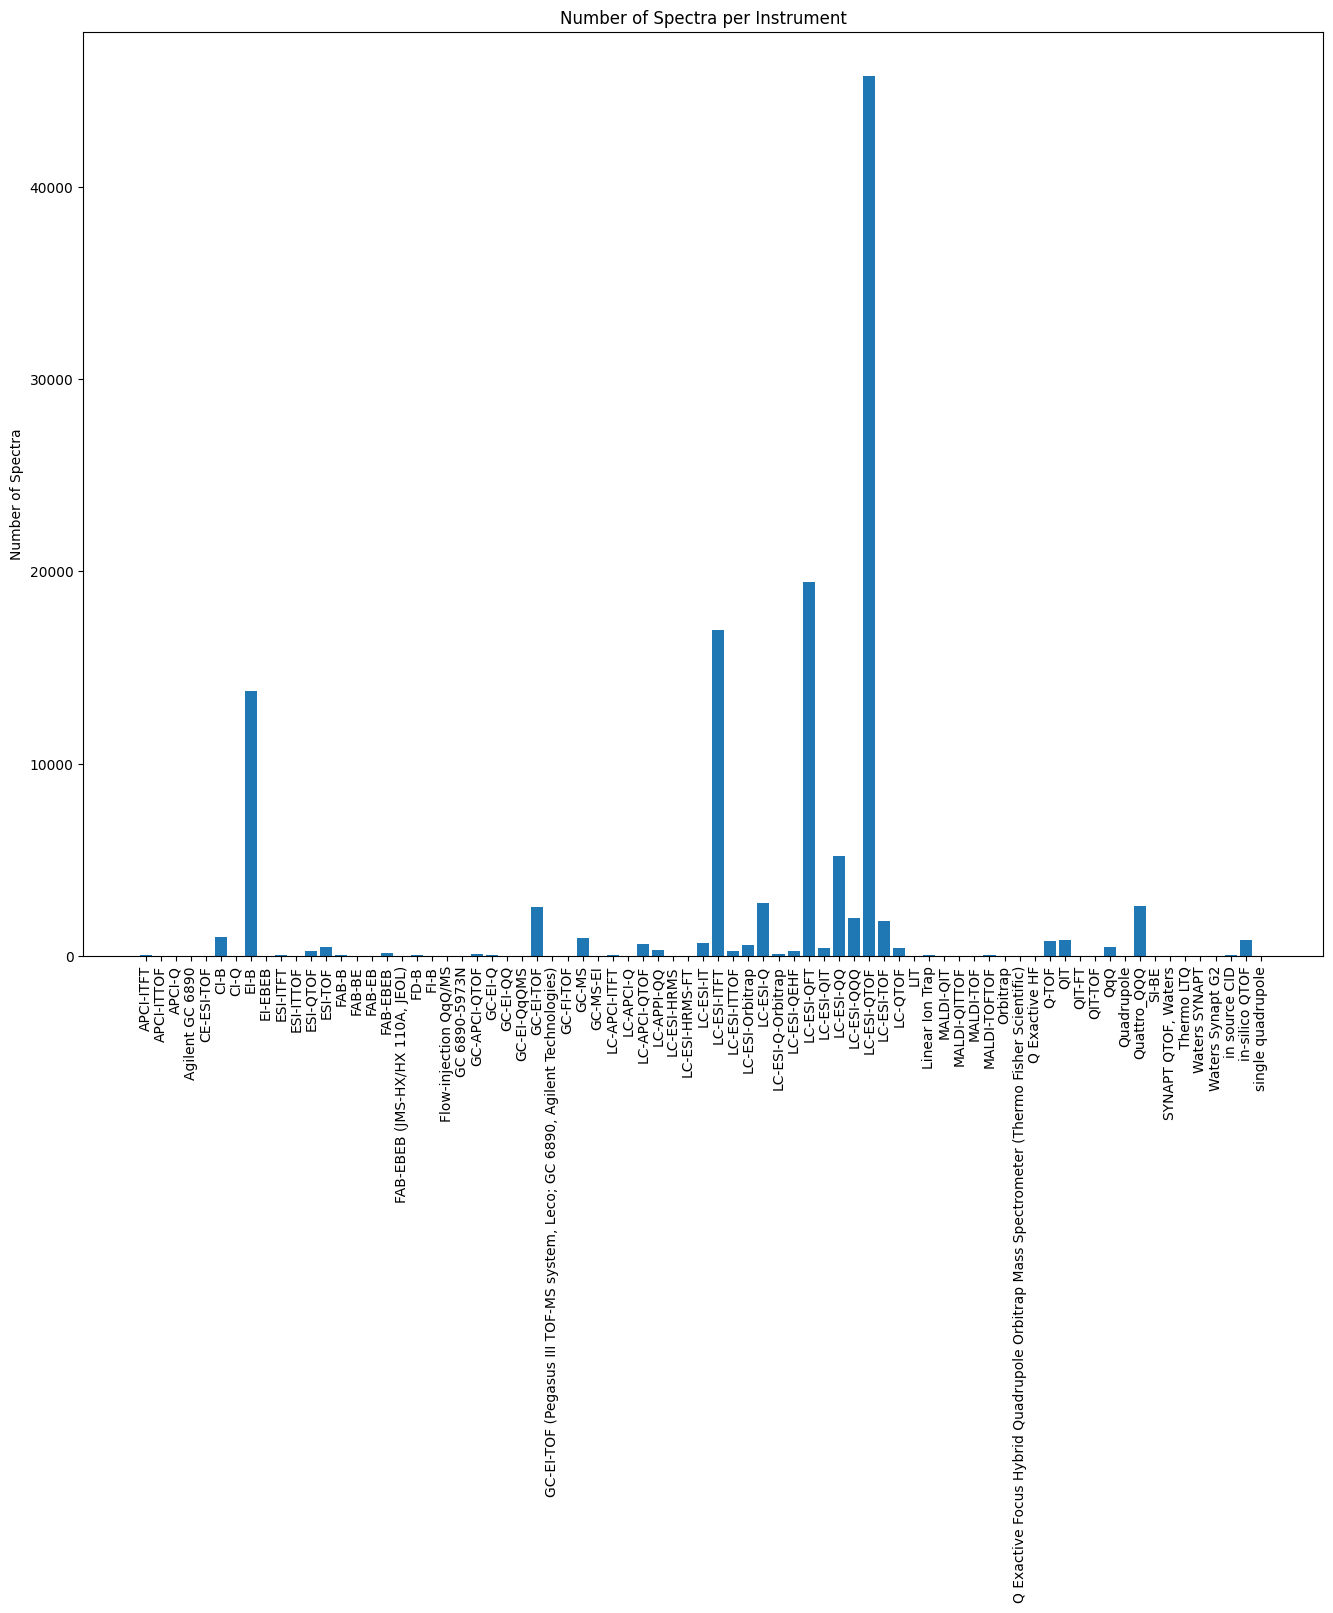

In [21]:
instruments = sorted(list(instrument_count_dict.keys()))
spectra_counts = [instrument_count_dict[instrument] for instrument in instruments]
plt.figure(figsize=(16,12))
plt.bar(instruments, spectra_counts)
plt.title('Number of Spectra per Instrument')
plt.ylabel('Number of Spectra')
plt.xticks(rotation = 90)
plt.show()